# Noise2Void - 3D Example

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

/home/sebi06/miniconda3/envs/n2v/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sebi06/miniconda3/envs/n2v/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sebi06/miniconda3/envs/n2v/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sebi06/miniconda3/envs/n2v/lib/python3.6/site-

# Download Example Data
Thanks to Romina Piscitello (Eaton Lab, MPI-CBG) for letting us use her data.

In [2]:
"""
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath='data/flywing-data.zip'
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/RKStdwKo4FlFrxE/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')
"""

# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [15]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [17]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = datagen.load_imgs_from_directory(directory = "data/", dims='ZYX')

print(len(imgs))

# Let's look at the shape of the image
print(imgs[0].shape)
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

1
(1, 15, 256, 256, 1)


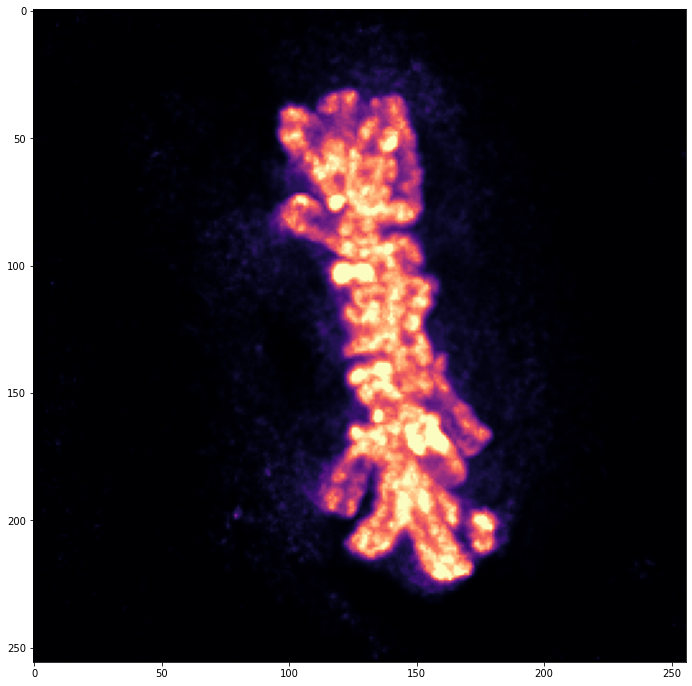

In [18]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(12,12))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

In [53]:
# Here we extract patches for training and validation.
patches = datagen.generate_patches_from_list(imgs[:1], shape=(6, 48, 48))

Generated patches: (400, 6, 48, 48, 1)


In [54]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:300]
X_val = patches[300:]

print(X.shape)
print(X_val.shape)

(300, 6, 48, 48, 1)
(100, 6, 48, 48, 1)


In [55]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

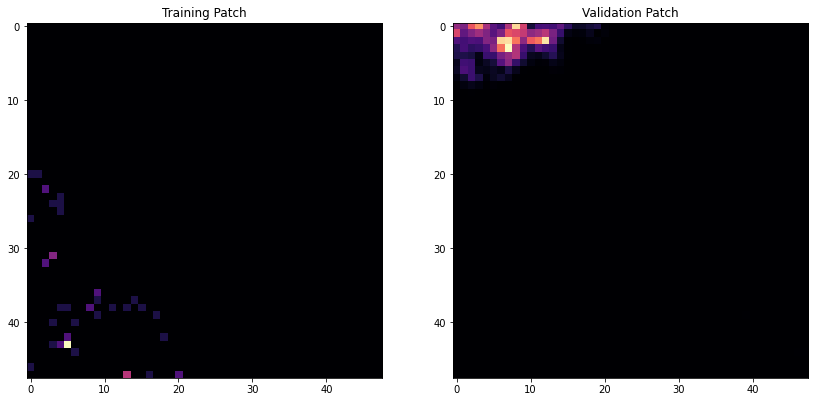

In [56]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,5,:,:,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,5,:,:,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [57]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(32, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['160.2151'],
 'stds': ['502.9983'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 2,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (32, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'probabilistic': False}

In [58]:
# a name used to identify the model
model_name = 'n2v_3D'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

## Training

In [59]:
history = model.train(X, X_val)

ValueError: training images must be evenly divisible by 4 along axes XYZ (axis Z has incompatible size 6)

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


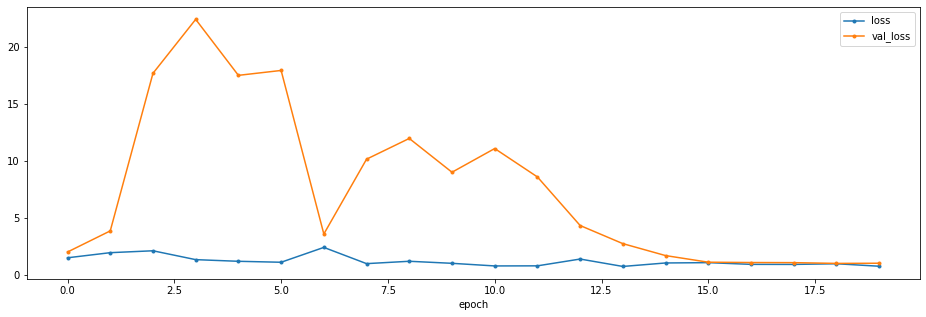

In [13]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [ ]:
model.export_TF()